graph-tool チートシート (SBM推定編) 「 url:https://qiita.com/yohm/items/5bb1d0c56e1b6ee2852c 」

SBM(Stochastic Block Model)とは・・・

・ネットワークを確率的に生成するモデルの1つ。

「ノードがいくつかの集合に分類され、そのブロックr内のノードiから

別のブロックsのノードjにリンクをもつ確率は、rとsに依存して決まる」

を仮定しているモデル。

In [2]:
import graph_tool.all as gt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

g = gt.collection.data["celegansneural"]

In [3]:
state = gt.minimize_nested_blockmodel_dl(g)

In [4]:
#state = gt.minimize_nested_blockmodel_dl(g,deg_corr = True)

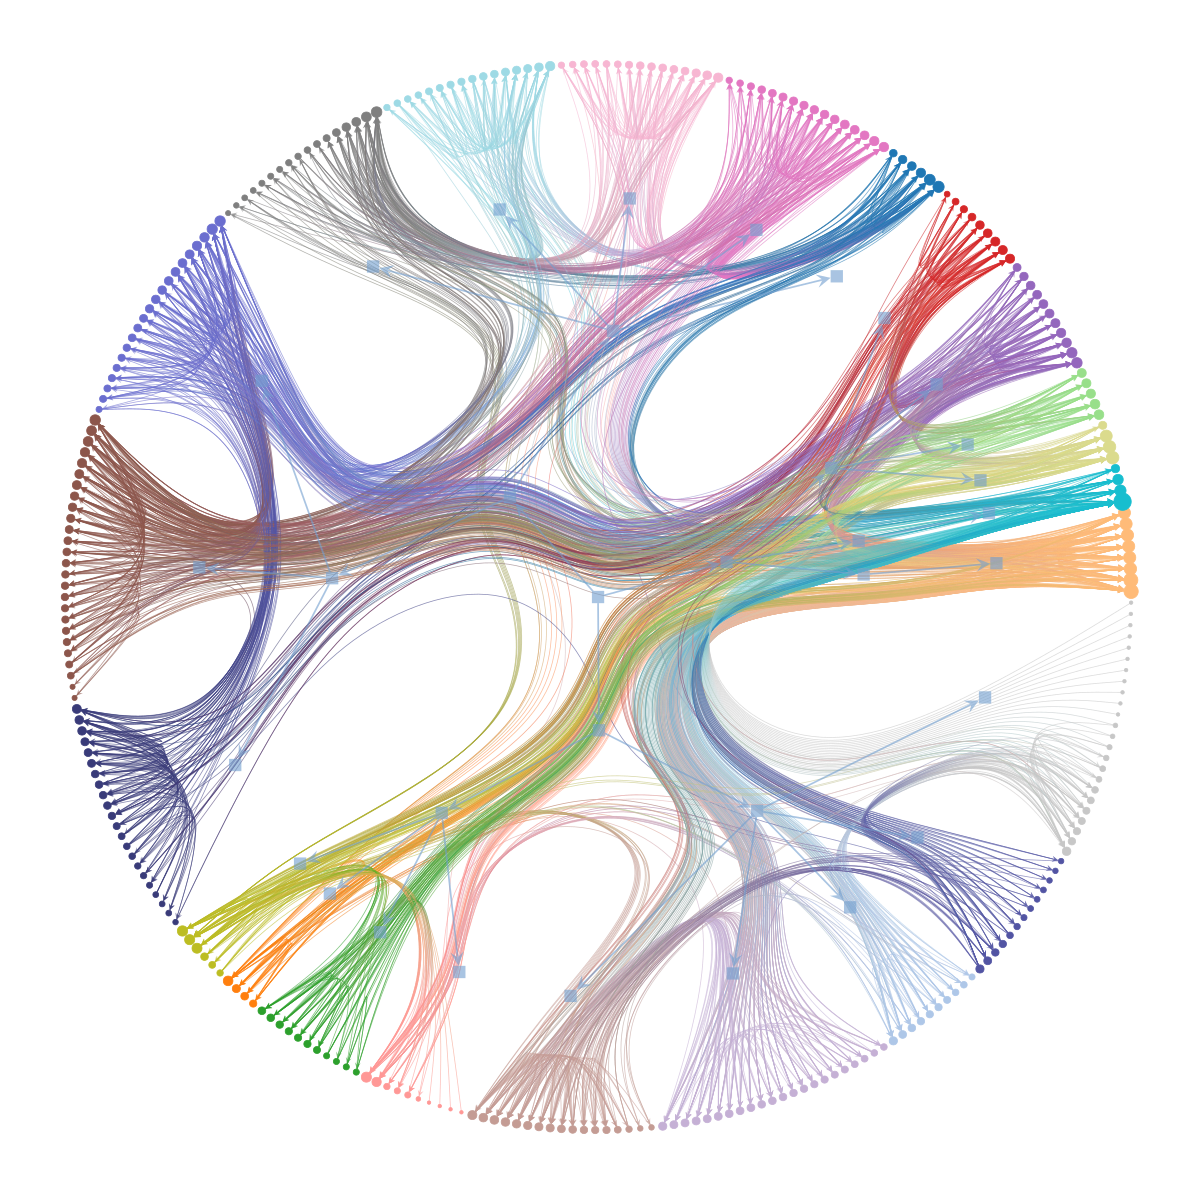

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4f8a283610, at 0x7f4f07541750>,
 <GraphView object, directed, with 331 vertices and 330 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f4f095b4a90, at 0x7f4f0756f5d0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f4f095b4a90, at 0x7f4f075f1850>, False), at 0x7f4f095b4a90>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4f095b4a90, at 0x7f4f07560bd0>)

In [5]:
state.draw()

In [6]:
state.entropy()             # => 8251.84

8569.491787764067

In [7]:
state.get_bs()

[PropertyArray([289, 289,  30,  30,  30, 289,  12,  12, 153, 153, 284, 153,
                 30,  12, 289, 262, 289, 262, 262, 262, 223, 223, 262, 175,
                175, 223, 262, 201, 284, 201, 201,  12, 201, 201, 175, 175,
                175, 223, 201, 284, 262, 262,  20, 175, 258, 201, 175, 175,
                175, 223, 201, 223,  12, 262, 262, 262, 262, 201, 201, 223,
                175, 201, 262, 153, 175, 153, 201, 153, 201, 201, 262, 262,
                153, 175, 175, 175, 223, 175, 223, 223,  77, 223, 223, 262,
                 30, 153,  30, 153, 223, 153, 223,  12, 289, 153, 223,  98,
                286, 224,  98, 289, 289, 289, 289, 289, 153, 289, 153, 284,
                289, 289, 289,  98, 153, 284, 289, 284, 289,  30,  30,  98,
                289, 289, 284,  98, 284, 255, 284, 284, 284, 153, 153, 153,
                153, 258, 284, 284, 284, 255, 284, 284, 284, 284, 258, 284,
                284,  47,  47, 284,  47,  47,  47, 105,  13,  13, 105, 105,
            

In [8]:
state = gt.minimize_nested_blockmodel_dl(g, state_args=dict(recs=[g.ep.value],
                                                            rec_types=["real-normal"]))

In [11]:
y = g.ep.value.copy()
y.a = np.log(y.a)

state = gt.minimize_nested_blockmodel_dl(g, state_args=dict(recs=[y], rec_types=["real-normal"]))

In [13]:
state.entropy() + np.log(g.ep.value.a).sum()

PropertyArray(13785.66283379)

In [14]:
state = gt.minimize_nested_blockmodel_dl(g, state_args=dict(recs=[g.ep.value], rec_types=["real-normal"]))

# improve solution with merge-split
state = state.copy(bs=state.get_bs() + [np.zeros(1)] * 4, sampling=True)

for i in range(100):
    ret = state.multiflip_mcmc_sweep(niter=10, beta=np.inf)

/tmp/c/Users/ogawataishi/ubuntu/envs/gt/lib/python3.11/site-packages/graph_tool/inference/blockmodel.py:390: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


In [17]:
# minimize level
def minimize_state_nest(state):
    i = 0
    while True:
        ls = state.get_levels()
        if i + 2 >= len(ls):  # keep the top-most level
            break
        if ls[i].get_nonempty_B() == ls[i+1].get_nonempty_B():
            state.delete_level(i+1)
        else:
            i += 1

minimize_state_nest(state)

AttributeError: 'NestedBlockState' object has no attribute 'delete_level'

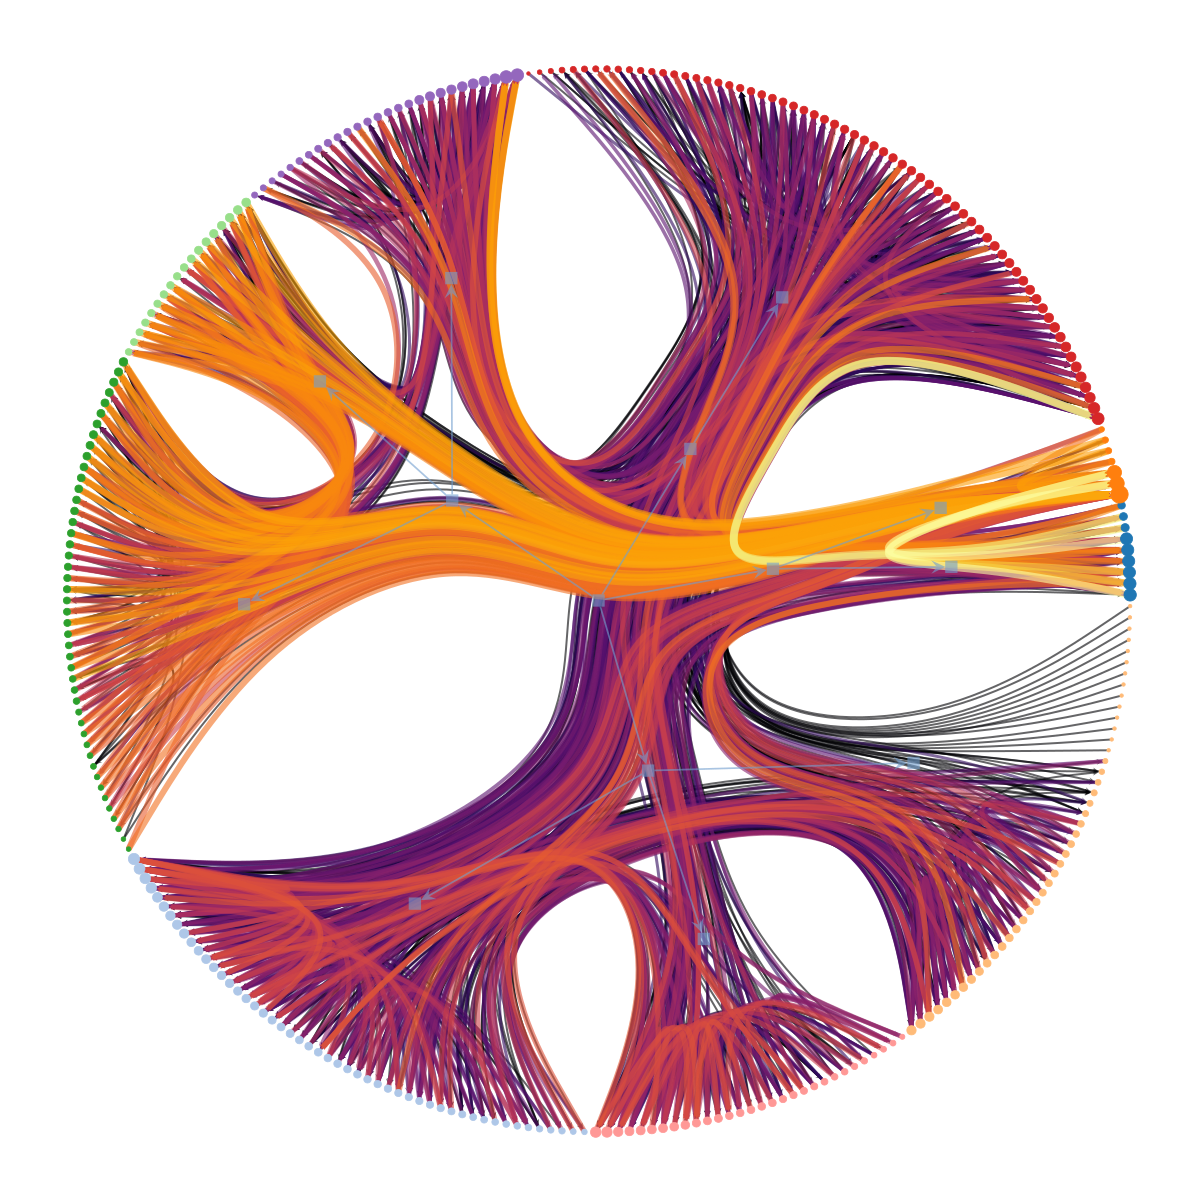

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4f8a283610, at 0x7f4f8a2c8050>,
 <GraphView object, directed, with 311 vertices and 310 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f4f075a3310, at 0x7f4ef2d9a490>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f4f075a3310, at 0x7f4ef2c07c50>, False), at 0x7f4f075a3310>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4f075a3310, at 0x7f4ef2c1d890>)

In [18]:
state.draw(
           edge_color=gt.prop_to_size(g.ep.value, power=1, log=True),
           ecmap=(matplotlib.cm.inferno, .6),
           eorder=g.ep.value,
           edge_pen_width=gt.prop_to_size(g.ep.value, 1, 4, power=1, log=True),
           edge_gradient=[])

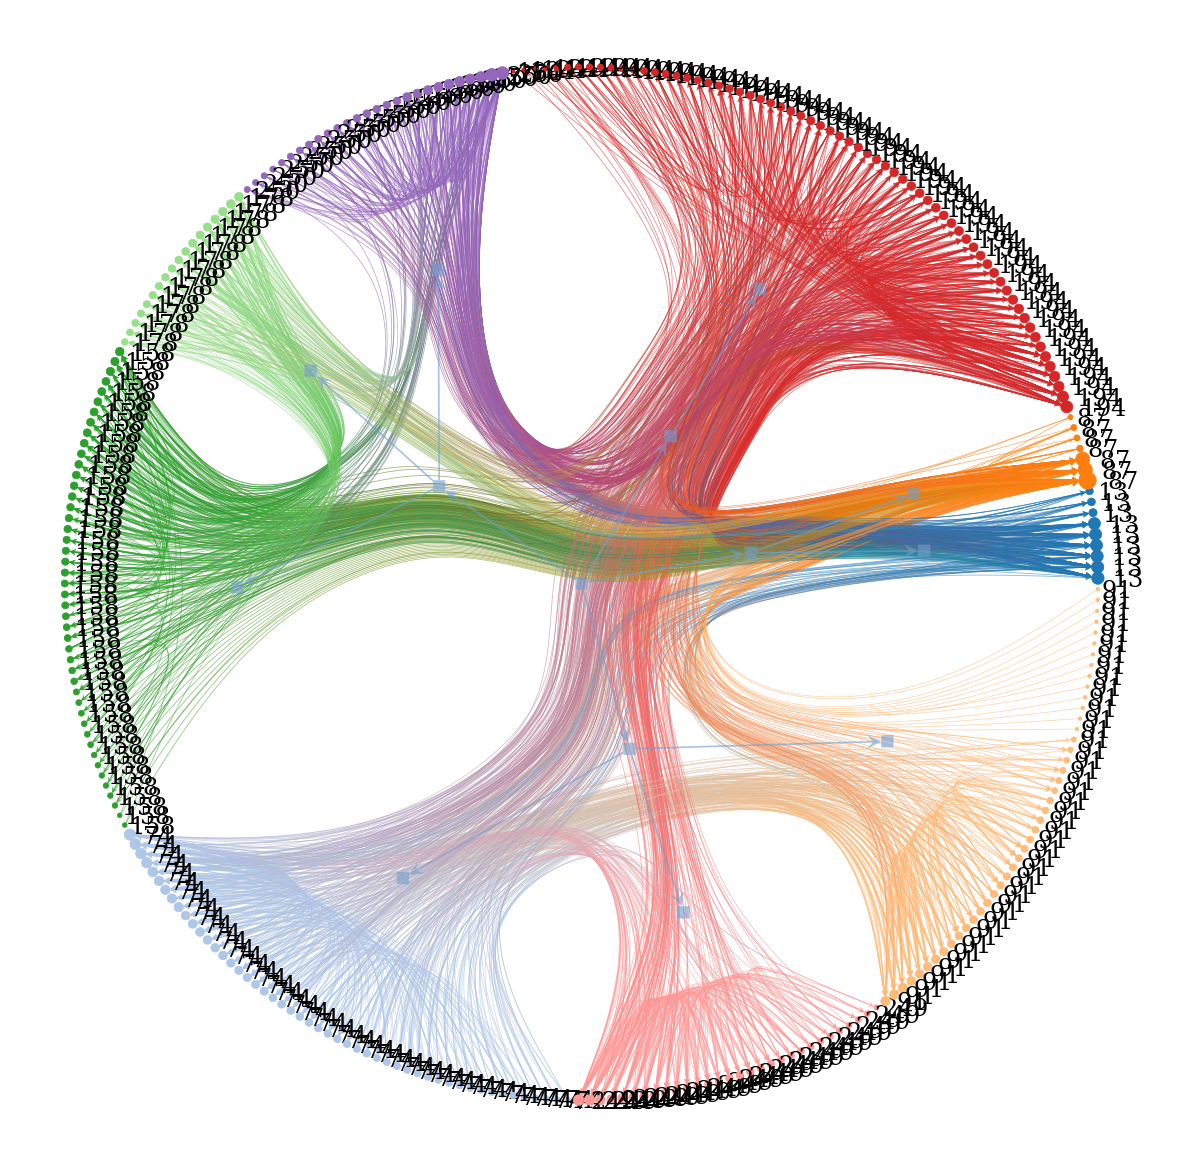

AttributeError: 'super' object has no attribute 'weight'

In [25]:
def draw_nested_with_node_names(state):
    b = state.g.new_vertex_property("int")
    b.a = state.get_bs()[0]
    pos,t,t_pos = state.draw(vertex_text = b, vertex_text_position=0,vertex_font_size = 12)
    x_pos = [pos[v][0] for v in g.vertices()]
    y_pos = [pos[v][1] for v in g.vertices()]
    angle = g.new_vertex_property("double")
    angle.a = np.arctan2(y_pos,x_pos)
    state.draw(
        pos=pos,
        edge_color=gt.prop_to_size(g.ep.weight, power=1, log=True),
        ecmap=(matplotlib.cm.inferno, .6),
        eorder=g.ep.weight, edge_pen_width=gt.prop_to_size(g.ep.weight, 1, 4, power=1, log=True),
        edge_gradient=[],
        vertex_text = g.vp.name,
        vertex_text_position=0,
        vertex_text_offset=[0,0],
        vertex_font_size=20,
        vertex_text_rotation = angle,
        output_size=(2000,2000))
    return pos,t,t_pos

pos,t,t_pos = draw_nested_with_node_names(state)

In [20]:
def calc_eij_wij(g, bs0, weight):
    B = int(bs0.max()) + 1
    eij = np.zeros((B,B))
    wij = np.zeros((B,B))
    for ni in g.vertices():
        for e in ni.out_edges():
            nj = e.target()
            i = g.vertex_index[ni]
            j = g.vertex_index[nj]
            bi = bs0[i]
            bj = bs0[j]
            eij[bi][bj] += 1
            wij[bi][bj] += weight[e]
    wij_avg = np.divide(wij, eij, out=np.zeros_like(wij), where=eij!=0)
    return eij, wij, wij_avg

bs0 = state.get_bs()[0]        # the lowest-level partition
eij,wij,wij_avg = calc_eij_wij(g, bs0, g.ep.value)
eij,wij,wij_avg

(array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0., 121.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,  94.]]),
 array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0., 421.,   0.],
        [  0.,   0.,   0., ...,   0.,   0., 159.]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.     

In [21]:
plt.matshow(eij_null)
plt.colorbar()

NameError: name 'eij_null' is not defined

/tmp/ipykernel_102/699132348.py:1: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(wij_avg))


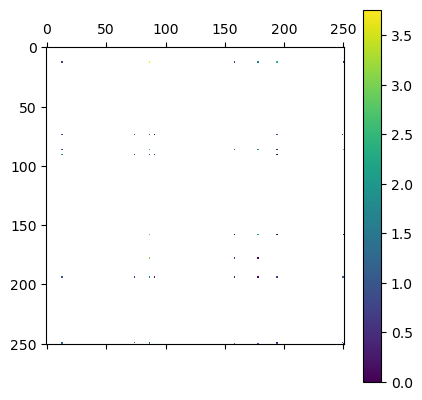

In [22]:
plt.matshow(np.log(wij_avg))
plt.colorbar()

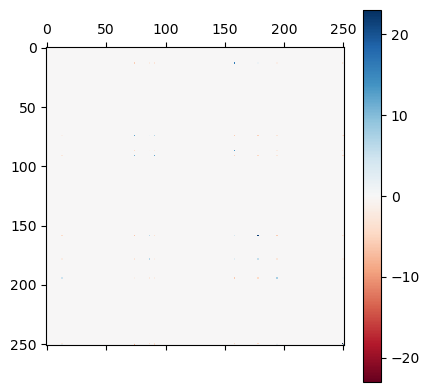

In [23]:
def calc_eij_null(g, bs0):
    B = int(bs0.max()) + 1
    out_deg_sum = [0] * B
    in_deg_sum = [0] * B
    for i,v in enumerate(g.vertices()):
        bi = bs0[i]
        in_deg_sum[bi] += v.in_degree()
        out_deg_sum[bi] += v.out_degree()
    null_ij = np.zeros((B,B))   # initialize BxB matrix
    E = sum(in_deg_sum)
    for i in range(B):
        for j in range(B):
            null_ij[i][j] = out_deg_sum[i] * in_deg_sum[j] / E
    return null_ij

eij_null = calc_eij_null(g, bs0)            # calculation of the null model

def plot_diff(eij, eij_null):
    dij = np.divide( eij - eij_null, np.sqrt(eij_null), out=np.zeros_like(eij), where=eij_null!=0)
    scale = max( abs(dij.max()), abs(dij.min()))
    plt.matshow(dij, vmin = -scale, vmax = scale, cmap = matplotlib.cm.RdBu)
    plt.colorbar()

plot_diff(eij, eij_null)